In [4]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from datetime import date

import re # for regular expressions
import string

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import pickle

import spacy

from gensim.models.word2vec import Word2Vec

from textblob import TextBlob

from sklearn import linear_model, preprocessing

from sklearn.linear_model import LinearRegression

import sklearn

1. store the cities and states in the US and its relation with abbreviation

In [5]:
def read_city():
    city = {}
    state = {}
    abbrev = {}
    city2state = {}
    state2abbrev = {}
    us_city_state = pd.read_csv("../../us_cities.csv")
    for i in range(len(us_city_state)):
        city_name = us_city_state.loc[i]["City"]
        state_name = us_city_state.loc[i]["State"]
        abbrev_name = us_city_state.loc[i]["Abbreviation"]
        if city_name not in city: 
            city[city_name] = 1
        if state_name not in state:
            state[state_name] = 1
        if abbrev_name not in abbrev:
            abbrev[abbrev_name] = 1
        if city_name not in city2state:
            city2state[city_name] = abbrev_name
        if state_name not in state2abbrev:
            state2abbrev[state_name] = abbrev_name
    return city, state, abbrev, city2state, state2abbrev

city, state, abbrev, city2state, state2abbrev = read_city()

2. Change data to pkl: month by month, should change the value of path. Also add city and state of each tweet

In [69]:

for i in range(1, 31):
    path = "../../6/2021_06_"
    day = "2021_06_"
    if i < 10:
        path = path + "0" + str(i)
        day = day + "0" + str(i)
    else:
        path += str(i)
        day += str(i)
    path += ".csv"
    tweets = pd.read_csv(path)
    df = tweets.drop(tweets[tweets["lang"] != "en"].index)
    df.insert(df.shape[1], 'isUS', False)
    df.insert(df.shape[1], 'city', False)
    df.insert(df.shape[1], 'state', False)
    for i in range(df.shape[0]):
        location = str(tweets.iloc[i,-7]).split(",")
        for l in location:
            l = l.strip()
            if l in city:
                df.loc[i, "isUS"] = True
                df.loc[i, "city"] = l
                df.loc[i, "state"] = city2state[l]
            elif l in state:
                df.loc[i, "isUS"] = True
                df.loc[i, "city"] = "null"
                df.loc[i, "state"] = state2abbrev[l]
            elif l in abbrev:
                df.loc[i, "isUS"] = True
                df.loc[i, "city"] = "null"
                df.loc[i, "state"] = l
    df = df.drop(df[df["isUS"] == False].index)
    df.to_pickle("data/"+day + ".pkl")
    print(path)

../../6/2021_06_01.csv


/Users/qiuyuanxu/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


../../6/2021_06_02.csv
../../6/2021_06_03.csv
../../6/2021_06_04.csv
../../6/2021_06_05.csv
../../6/2021_06_06.csv
../../6/2021_06_07.csv
../../6/2021_06_08.csv
../../6/2021_06_09.csv
../../6/2021_06_10.csv
../../6/2021_06_11.csv
../../6/2021_06_12.csv
../../6/2021_06_13.csv
../../6/2021_06_14.csv
../../6/2021_06_15.csv
../../6/2021_06_16.csv
../../6/2021_06_17.csv
../../6/2021_06_18.csv
../../6/2021_06_19.csv
../../6/2021_06_20.csv
../../6/2021_06_21.csv
../../6/2021_06_22.csv
../../6/2021_06_23.csv
../../6/2021_06_24.csv
../../6/2021_06_25.csv
../../6/2021_06_26.csv
../../6/2021_06_27.csv
../../6/2021_06_28.csv
../../6/2021_06_29.csv
../../6/2021_06_30.csv


3. Store the value of polarity for each day: month by month, shoule change the value of day

In [71]:
polarity = []
polarity_notNull = []

for i in range(1, 31):
    day = "2021_06_"
    if i < 10:
        day = day + "0" + str(i)
    else:
        day += str(i)
    df = pd.read_pickle("data/"+day + ".pkl")
    
    p_notnull = 0
    cnt = 0
    for i in range(df.shape[0]):
        blob = TextBlob(str(df[i:i+1]["text"]))
        if blob.sentiment[0] != 0:
            p_notnull += blob.sentiment[0]
            cnt += 1
    p_notnull /= cnt
    polarity_notNull.append(p_notnull)
    with open("Polarity/" + day + ".pkl", "wb") as f:
        pickle.dump(p_notnull, f)
    print(day)

2021_06_01
2021_06_02
2021_06_03
2021_06_04
2021_06_05
2021_06_06
2021_06_07
2021_06_08
2021_06_09
2021_06_10
2021_06_11
2021_06_12
2021_06_13
2021_06_14
2021_06_15
2021_06_16
2021_06_17
2021_06_18
2021_06_19
2021_06_20
2021_06_21
2021_06_22
2021_06_23
2021_06_24
2021_06_25
2021_06_26
2021_06_27
2021_06_28
2021_06_29
2021_06_30


4. input google trend

In [25]:

path = "../../google trend.csv"
df = pd.read_csv(path)
x_google = list(df["value"])
with open('input/google_trend.pkl', 'wb') as f:
   pickle.dump(x_google, f)

5. input x_train: polarity

In [26]:
x_polarity = []
for month in range(6, 10):
    max_day = 31
    if month == 6 or month == 9: max_day = 30
    for day in range(1, max_day+1):
        path = "Polarity/2021_0"+str(month)+"_"
        if day < 10:
            path += "0"+str(day)+".pkl"
        else:
            path += str(day) + ".pkl"
        data=pd.read_pickle(path)
        x_polarity.append(data)

with open('input/polarity.pkl', 'wb') as f:
   pickle.dump(x_polarity, f)

6. input y: new cases, diff and date

In [73]:
df = pd.read_csv("../../data_y.csv")
with open('input/new_cases.pkl', 'wb') as f:
   pickle.dump(list(df["new cases"]), f)
with open('input/date.pkl', 'wb') as f:
   pickle.dump(list(df["date"]), f)
with open('input/diff.pkl', 'wb') as f:
   pickle.dump(list(df["diff"]), f)


7. read pickle: change input to list

In [6]:
import pickle
def read_pkl(param):
    path = "input/" + param + ".pkl"
    df=open(path,'rb')
    data3=pickle.load(df)
    return data3

X_train = []
x_1 = read_pkl("google_trend")
X_train.append(x_1)
x_2 = read_pkl("polarity")
X_train.append(x_2)
X_train = np.array(X_train)

# Y_train = []
y_1 = read_pkl("new_cases")
y_1 = [(i-min(y_1))/(max(y_1)-min(y_1)) for i in y_1]
# Y_train.append(y_1)
y_2 = read_pkl("diff")
y_2 = [(i-min(y_2))/(max(y_2)-min(y_2)) for i in y_2]
# Y_train.append(y_2)
# Y_train = np.array(Y_train)

date = read_pkl("date")

draw picture: plt plot

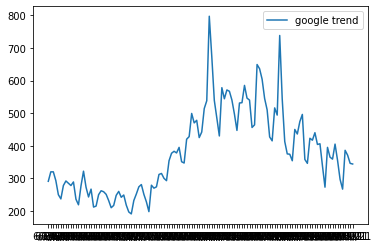

Text(0, 0.5, 'diff')

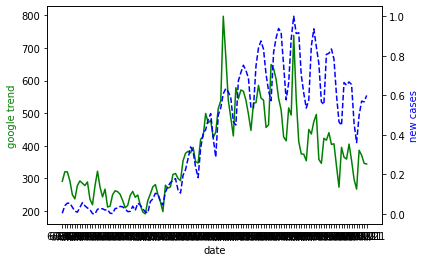

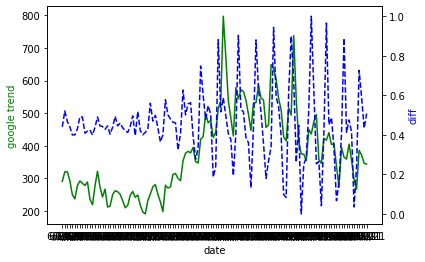

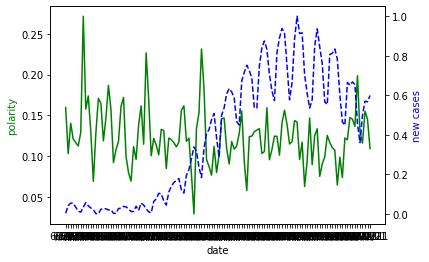

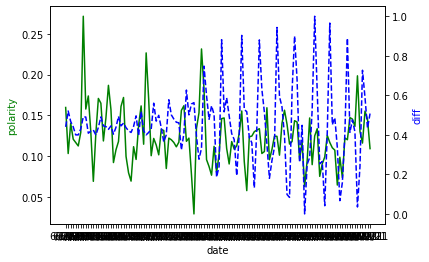

In [8]:
plt.plot(date, x_1, label = "google trend")
plt.legend()
plt.show()

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()     
ax1.plot(date,x_1,'g-')
ax2.plot(date, y_1,'b--')
ax1.set_xlabel('date')    
ax1.set_ylabel('google trend',color = 'g') 
ax2.set_ylabel('new cases',color = 'b')   

fig,bx1 = plt.subplots()
bx2 = bx1.twinx()        
bx1.plot(date,x_1,'g-')
bx2.plot(date, y_2,'b--')
bx1.set_xlabel('date')  
bx1.set_ylabel('google trend',color = 'g')  
bx2.set_ylabel('diff',color = 'b') 

fig,cx1 = plt.subplots()
cx2 = cx1.twinx()        
cx1.plot(date,x_2,'g-')
cx2.plot(date, y_1,'b--')
cx1.set_xlabel('date') 
cx1.set_ylabel('polarity',color = 'g')  
cx2.set_ylabel('new cases',color = 'b') 

fig,dx1 = plt.subplots()
dx2 = dx1.twinx()     
dx1.plot(date,x_2,'g-')
dx2.plot(date, y_2,'b--')
dx1.set_xlabel('date')  
dx1.set_ylabel('polarity',color = 'g')  
dx2.set_ylabel('diff',color = 'b')  

prediction model

In [29]:
linear_models = {
    'LinearRegression': linear_model.LinearRegression(),

    'Ridge': linear_model.Ridge(),

    'Lars': linear_model.Lars,

    'Lasso': linear_model.Lasso(),

    'LassoLars': linear_model.LassoLars(),

    'ElasticNet': linear_model.ElasticNet(),

    'OrthogonalMatchingPursuit': linear_model.OrthogonalMatchingPursuit(),

    'BayesianRegression': linear_model.BayesianRidge(),
    'AutomaticRelevanceDetermination': linear_model.ARDRegression(),

    'LogisticRegression': linear_model.LogisticRegression(),

    #'TweedieRegressor': linear_model.TweedieRegressor(),
#    'PoissonRegressor': linear_model.PoissonRegressor(),

    'StochasticGradientDescent': linear_model.SGDRegressor(),

    'Perceptron': linear_model.Perceptron(),

    'PAARegressor': linear_model.PassiveAggressiveRegressor(),

    'RANSAC': linear_model.RANSACRegressor(),
    'TheilSenRegressor': linear_model.TheilSenRegressor(),
    # 'Huber': linear_model.Huber(),
    'HuberRegressor': linear_model.HuberRegressor(),

    'PolynomialFeatures': preprocessing.PolynomialFeatures(),
}

reshape x and y train data

In [94]:
X_train_reshape = X_train.T



linear regression

In [31]:
linreg = LinearRegression()

linreg.fit(X_train_reshape[0:31], y_2[0:31])

LinearRegression()

predict

MSE: 0.004095740443820856
RMSE: 0.06399797218522518


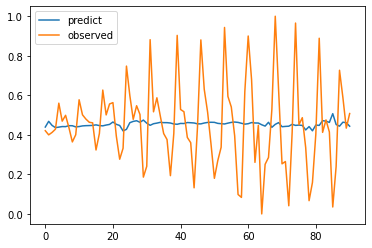

In [115]:
from sklearn import metrics
linreg = LinearRegression()
y_pred_linear = []
y_2_linear = []
mse_linear = []
rmse_linear = []
for i in range(91):
    linreg.fit(X_train_reshape[0:31+i, 1:2], y_2[0:31+i])
    y_pred = linreg.predict(X_train_reshape[31+i:32+i, 1:2])
    y_pred_linear.append(y_pred)
    y_2_linear.append(y_2[31+i:32+i])

print("MSE:",metrics.mean_squared_error(y_2_linear[len(y_2_linear) - 1], y_pred_linear[len(y_pred_linear) - 1]))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_2_linear[len(y_2_linear) - 1], y_pred_linear[len(y_pred_linear) - 1])))

plt.plot(y_pred_linear, label="predict")
plt.plot(y_2_linear, label="observed")
plt.legend()
plt.show()
# plt.scatter(x_2, y_2)


arima model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-108.821, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-115.651, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-114.284, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-115.035, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=38.326, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-115.050, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.388 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-109.981, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-115.746, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-113.778, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-113.790, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=39.901, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-111.857, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
To

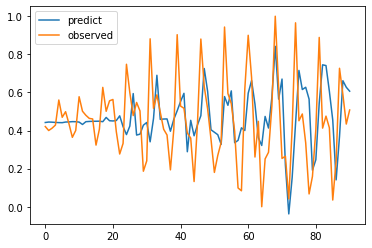

In [112]:
from pmdarima.arima import auto_arima
y_pred_linear = []
y_2_linear = []
for i in range(91):
    model = auto_arima(y_2[0:30+i], trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(y_2[0:30+i])

    forecast = model.predict(n_periods=1)
    y_pred_linear.append(forecast)
    y_2_linear.append(y_2[31+i:32+i])

print("MSE:",metrics.mean_squared_error(y_2_linear[len(y_2_linear) - 1], y_pred_linear[len(y_pred_linear) - 1]))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_2_linear[len(y_2_linear) - 1], y_pred_linear[len(y_pred_linear) - 1])))

plt.plot(y_pred_linear, label="predict")
plt.plot(y_2_linear, label="observed")
plt.legend()
plt.show()

SVR model

MSE: 0.004029879946897488
RMSE: 0.06348133542150391


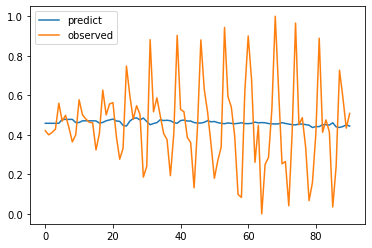

In [117]:
y_pred_linear = []
y_2_linear = []
for i in range(91):
    svr = sklearn.svm.SVR(kernel ='rbf',degree = 3,gamma ='auto',coef0 = 0.0,tol = 0.001,C = 1.0,epsilon = 0.1,shrinking = True,cache_size = 200,verbose = False,max_iter = -1)
    svr.fit(X_train_reshape[0:31+i,1:2], y_2[0:31+i])

    y_pred = svr.predict(X_train_reshape[31+i:32+i,1:2])
    y_pred_linear.append(y_pred)
    y_2_linear.append(y_2[31+i:32+i])

print("MSE:",metrics.mean_squared_error(y_2_linear[len(y_2_linear) - 1], y_pred_linear[len(y_pred_linear) - 1]))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_2_linear[len(y_2_linear) - 1], y_pred_linear[len(y_pred_linear) - 1])))

plt.plot(y_pred_linear, label="predict")
plt.plot(y_2_linear, label="observed")
plt.legend()
plt.show()

 LSTM model

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [100]:
# create and fit the LSTM networkmodel 
y_pred_linear = []
y_2_linear = []
# y_2 = np.array(y_2)
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, 1)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_train_reshape, y_2, epochs=10, batch_size=1, verbose=2)
# y_pred = model.predict(X_test)


for i in range(91):

    model = Sequential()
    model.add(LSTM(4, input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train_reshape[0:31+i], y_2[0:31+i], epochs=100, batch_size=1, verbose=2)

    y_pred = model.predict(X_train_reshape[31+i:32+i])
    y_pred_linear.append(y_pred)
    y_2_linear.append(y_2[31+i:32+i])

# plt.plot(y_pred_linear, label="predict")
# plt.plot(y_2_linear)
# plt.legend()


<class 'numpy.ndarray'>


ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'float'>"})

In [ ]:

y_pred = model.predict(X_test)
print("MSE:",metrics.mean_squared_error(y_test, y_pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

ARIMA X

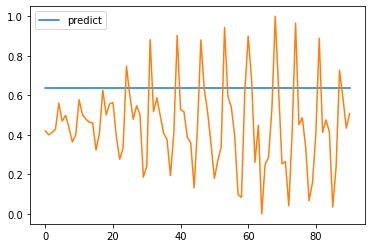

In [66]:
import statsmodels.api as sm
y_pred_linear = []
y_2_linear = []
for i in range(91):
    modle = sm.tsa.statespace.SARIMAX(y_2[0:31], exog=X_train_reshape[0:31]).fit(disp=-1)
# modle.summary()

    y_pred = modle.forecast(steps=1, exog=X_train_reshape[31:32])
    y_pred_linear.append(y_pred)
    y_2_linear.append(y_2[31+i:32+i])

plt.plot(y_pred_linear, label="predict")
plt.plot(y_2_linear)
plt.legend()
